In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import math

from collections import OrderedDict

In [2]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:
raw_train_data = pd.read_csv("train.csv")
raw_test_data = pd.read_csv("test.csv")

In [4]:
raw_train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Functions

In [5]:
def plot_unsorted(x, y):
    order = np.argsort(x)
    xs = np.array(x)[order]
    ys = np.array(y)[order]
    plt.plot(xs, ys, color = 'r')

In [6]:
def scatter_unsorted(x, y):
    order = np.argsort(x)
    xs = np.array(x)[order]
    ys = np.array(y)[order]
    plt.scatter(xs, ys, color = 'b')

In [7]:
def scatter_unsorted_3d(x1,x2,y):
    order = np.argsort(x1)
    xs = np.array(x1)[order]
    xm = np.array(x2)[order]
    ys = np.array(y)[order]

    fig = plt.figure()
    ax = fig.gca(projection = '3d')
    ax.scatter(xs,xm,ys)

## Pre-Processing

In [8]:
# find correclation between one feature and desired output
corr_score = raw_train_data[['LotArea', 'SalePrice']].corr('pearson')
print(corr_score)

            LotArea  SalePrice
LotArea    1.000000   0.263843
SalePrice  0.263843   1.000000


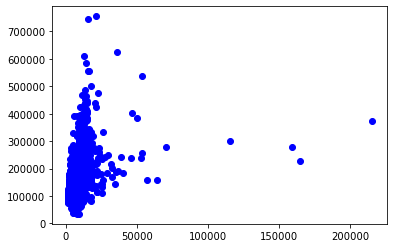

In [9]:
scatter_unsorted(raw_train_data['LotArea'],raw_train_data['SalePrice'])

In [10]:
corr_score = raw_train_data[['BedroomAbvGr', 'SalePrice']].corr('spearman')
print(corr_score)

              BedroomAbvGr  SalePrice
BedroomAbvGr      1.000000   0.234907
SalePrice         0.234907   1.000000


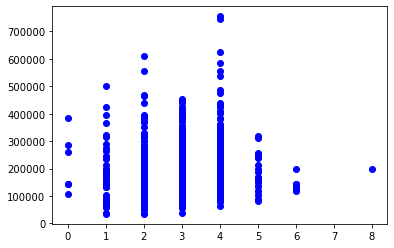

In [11]:
scatter_unsorted(raw_train_data['BedroomAbvGr'],raw_train_data['SalePrice'])

In [12]:
corr_score = raw_train_data[['OverallQual', 'SalePrice', ]].corr('spearman')
print(corr_score)

             OverallQual  SalePrice
OverallQual     1.000000   0.809829
SalePrice       0.809829   1.000000


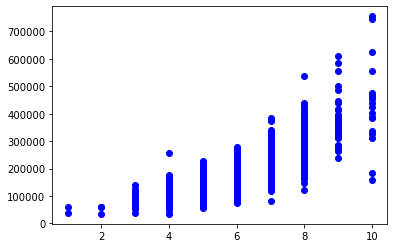

In [13]:
scatter_unsorted(raw_train_data['OverallQual'],raw_train_data['SalePrice'])

In [14]:
corr_score = raw_train_data[['OverallCond', 'SalePrice']].corr('spearman')
print(corr_score)

             OverallCond  SalePrice
OverallCond     1.000000  -0.129325
SalePrice      -0.129325   1.000000


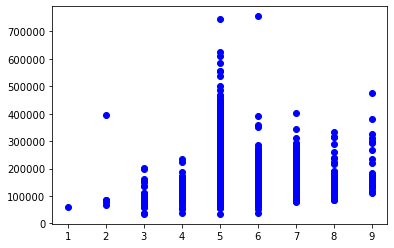

In [15]:
scatter_unsorted(raw_train_data['OverallCond'],raw_train_data['SalePrice'])

In [16]:
# Trim data and filter out unnecessary data
train_data = raw_train_data.filter(['LotArea','OverallQual','OverallCond','BedroomAbvGr','SalePrice'])

In [17]:
# drop outlier
from scipy import stats
train_data  = train_data[(np.abs(stats.zscore(train_data)) < 3).all(axis=1)]

In [18]:
train_data

,LotArea,OverallQual,OverallCond,BedroomAbvGr,SalePrice
0,8450,7,5,3,208500
1,9600,6,8,3,181500
2,11250,7,5,3,223500
3,9550,7,5,3,140000
4,14260,8,5,4,250000
...,...,...,...,...,...
1454,7500,7,5,2,185000
1455,7917,6,5,3,175000
1456,13175,6,6,3,210000
1458,9717,5,6,2,142125


In [19]:
corr_score = train_data[['LotArea', 'SalePrice']].corr('pearson')
print(corr_score)

            LotArea  SalePrice
LotArea    1.000000   0.330867
SalePrice  0.330867   1.000000


In [20]:
corr_score = train_data[['BedroomAbvGr', 'SalePrice']].corr('spearman')
print(corr_score)

              BedroomAbvGr  SalePrice
BedroomAbvGr      1.000000   0.242141
SalePrice         0.242141   1.000000


In [21]:
corr_score = train_data[['OverallCond', 'SalePrice']].corr('spearman')
print(corr_score)

             OverallCond  SalePrice
OverallCond     1.000000  -0.160464
SalePrice      -0.160464   1.000000


In [22]:
corr_score = train_data[['OverallQual', 'SalePrice']].corr('spearman')
print(corr_score)

             OverallQual  SalePrice
OverallQual     1.000000   0.804706
SalePrice       0.804706   1.000000


## Question 2 (b)

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [24]:
X_train = train_data[['LotArea','OverallQual','OverallCond','BedroomAbvGr']]
X_1_train = train_data['LotArea']
X_2_train = train_data['OverallQual']
X_3_train = train_data['OverallCond']
X_4_train = train_data['BedroomAbvGr']
y_train = train_data['SalePrice']

from the previous data pre-processing steps, we found that there are four categories that we want to research on

LotArea: from the correlation test, we found that it is positively correlated to SalesPrice, but not a very strong correlation. Althought from the scatter plot we find that the data seems to be clustered, with still some pontential outliers. The best way to classify this data I think is using clustering method. But from our experience, lotArea still could be associated to SalesPrice in normal understanding

Overall Quality: it is a n Ordinal data, we found a very strong correlation between overall quality and SalesPrice, so we select this feature

Overall Condition: it is also an ordinal data, althought correlation test gives us negatively correlated behavior, we were supposed to put it into consideration here, for this least square question, I want to look for feature that is only postively correlated to SalePrice. I can't mix feature that are either positively or negatively correlated to label, it will mess up my regression model.
However, we don't think correlation test gives us a good result, because fromthe scatter plot, we can see a general trend of price rising up while condition increases, the problem is that mode is condition = 5, it skewed the correlation test because of that. we were not sure those are outliers that we should remove. It is better to use other data processing techniques to replace that data such that we can get a better processed data set. However we decide to put the entire data into our model to see what happens, because in general there is an observable trend.

BedroomAbove grade: it is also an ordinal data, our hypothesis is that the more bedroom, the more pricy it would be. We also got a positive but weak correlation.

We will not be using other feature for right now, because other features includes uncertainty behavior that needs more analysis to determine if we should use as training feature. Also a lot of data has categorical features, binary like features, which is not good while we are using least square to find regression model.

In this homework, we will be using two methods. The first one is only to use one feature but polynomial linear regression.The second method, we will be taking consideration of all four features, which we will be using multi-variate linear regression

In [25]:
# Least square using several feature
#fit
one_array = np.ones(( len(train_data['LotArea']),  ))

#theta using closed form
new_X_train = np.stack([ one_array, X_1_train,X_2_train, X_3_train, X_4_train], axis=1)
theta_best = np.linalg.inv(new_X_train.T.dot(new_X_train)).dot(new_X_train.T).dot(y_train)

In [26]:
#predict
y_train_pred = new_X_train.dot(theta_best)
print(r2_score(y_train, y_train_pred))

0.6996977640075646


In [27]:
# lease square suing one feature
#fit
one_array = np.ones(( len(train_data['LotArea']),  ))

#theta using closed form
new_X_train = np.stack([ one_array, X_1_train,X_1_train**2,X_1_train**3,X_1_train**4 ], axis=1)
theta_best = np.linalg.inv(new_X_train.T.dot(new_X_train)).dot(new_X_train.T).dot(y_train)

#new_X_train = np.hstack((one_array, X_1_train, X_train**2))

0.16934769528258264


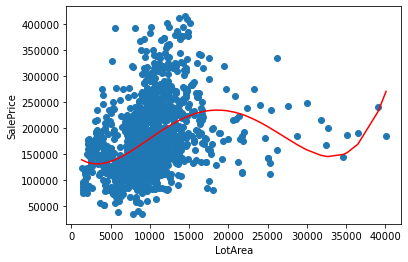

In [28]:
#predict
y_train_pred = new_X_train.dot(theta_best)
print(r2_score(y_train, y_train_pred))

plt.xlabel('LotArea')
plt.ylabel('SalePrice')
plt.scatter(X_1_train, y_train)
plot_unsorted(X_1_train, y_train_pred)

Text(0, 0.5, 'SalesPrice')

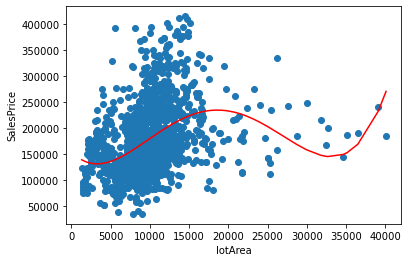

In [29]:
#method 2 as comparison, using Library

polynomial_features = PolynomialFeatures(degree= 4, include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
pipeline.fit(X_1_train[:, np.newaxis], y_train)

plt.scatter(X_1_train, y_train)
plot_unsorted(X_1_train, pipeline.predict(X_1_train[:, np.newaxis]))
plt.xlabel('lotArea')
plt.ylabel('SalesPrice')

## Question 2(c)

In [30]:
#Multiple feature find best alpha
#ridge
alpha_list = [0.1, 0.18, 0.20, 0.5, 0.9, 1.3, 1.5, 1.8, 2.0]
regression_loss_list =[]
for i in alpha_list:
    RidgeModel = Ridge(alpha = i) 
    RidgeModel.fit(X_train, y_train) 
    Ridge_prediction = RidgeModel.predict(X_train)
    regression_loss = r2_score(y_train, Ridge_prediction)
    regression_loss_list.append(regression_loss)
print(regression_loss_list)

[0.6996977628769925, 0.6996977603447885, 0.6996977594857045, 0.6996977357539602, 0.6996976725005221, 0.6996975731576829, 0.6996975099655374, 0.6996973982907964, 0.6996973125907398]


score is 0.16934769528258242


D:\CODING------PROGRAMMING\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.26046e-30): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Text(0, 0.5, 'SalesPrice')

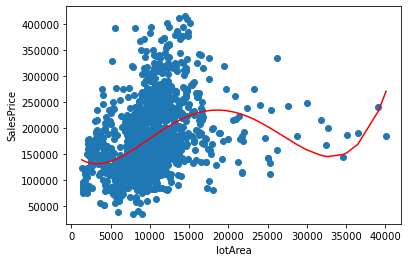

In [31]:
# Single Feature, Polynomial 4
# Ridge--------L2 regularization
polynomial_features = PolynomialFeatures(degree= 4, include_bias=False)
linear_regression = Ridge(alpha=0.9)
pipeline_r = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
pipeline_r.fit(X_1_train[:, np.newaxis], y_train)

print('score is '+ str(r2_score(y_train, pipeline_r.predict(X_1_train[:, np.newaxis]))))
plt.scatter(X_1_train, y_train)
plot_unsorted(X_1_train, pipeline_r.predict(X_1_train[:, np.newaxis]))
plt.xlabel('lotArea')
plt.ylabel('SalesPrice')

In [48]:
#Multiple feature find best alpha
#lasso
alpha_list = [0.1, 0.18, 0.20, 0.5, 0.9]
regression_loss_list =[]
for i in alpha_list:
    lassoModel = Lasso(alpha = i) 
    lassoModel.fit(X_train, y_train) 
    lasso_prediction = lassoModel.predict(X_train)
    regression_loss = r2_score(y_train, lasso_prediction)
    regression_loss_list.append(regression_loss)
print(regression_loss_list)

[0.6996977639991868, 0.6996977639804205, 0.6996977639740535, 0.6996977637981203, 0.6996977633289653]


score is 0.15793100039006402


D:\CODING------PROGRAMMING\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2549925317233.919, tolerance: 605633342.0608436
  model = cd_fast.enet_coordinate_descent(


Text(0, 0.5, 'SalesPrice')

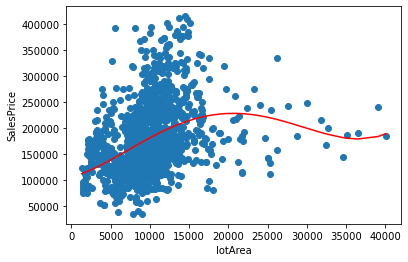

In [33]:
# Single Feature, Polynomial 4
# Lasso-------------L1 regularization
polynomial_features = PolynomialFeatures(degree= 4, include_bias=False)
linear_regression = Lasso(alpha=0.9)
pipeline_l = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
pipeline_l.fit(X_1_train[:, np.newaxis], y_train)

print('score is '+ str(r2_score(y_train, pipeline_l.predict(X_1_train[:, np.newaxis]))))
plt.scatter(X_1_train, y_train)
plot_unsorted(X_1_train, pipeline_l.predict(X_1_train[:, np.newaxis]))
plt.xlabel('lotArea')
plt.ylabel('SalesPrice')

from r2_score we know that polynomial linear regression models don't fit the data good, the loss is enormous. 

multivariate models perform much better with r_2 score of approximately 0.7, both lasso and ridge model perform similarly, and similarly as ordinary linear regression. So using ridge and lasso didn't really change much compared to unregularized models. 

as we increase lambda for ridge and lasso models, r_2 score decrease a tiny little bit, but still decreasing. So lambda didn't play a big role in our selected features for our model. 

## Question 2 (d)

In [35]:
x_test = np.array(raw_test_data[['LotArea','OverallQual','OverallCond','BedroomAbvGr']])

In [45]:
result_prediction = lassoModel.predict(x_test)

In [37]:
result_df = pd.DataFrame(data = result_prediction, columns = ['SalePrice'])

In [42]:
csvfile = result_df.to_csv('result_HP.csv',index_label = 'Id')

In [49]:
result_prediction

array([135890.96669744, 188378.54794807, 147662.63981791, ...,
       173393.00516124, 136811.403712  , 211989.90231484])